In [1]:
import jax
from jax import numpy as jnp

jax.config.update("jax_enable_x64", True)

from matplotlib import pyplot as plt

from diffrax import Tsit5

from models import NeuralODE, MLPVectorField
from system import SystemTrajectoryGenerator, MetriplecticSystem
from train import Trainer

print("JAX devices:", jax.devices())
print("Default backend:", jax.default_backend())

JAX devices: [CpuDevice(id=0)]
Default backend: cpu


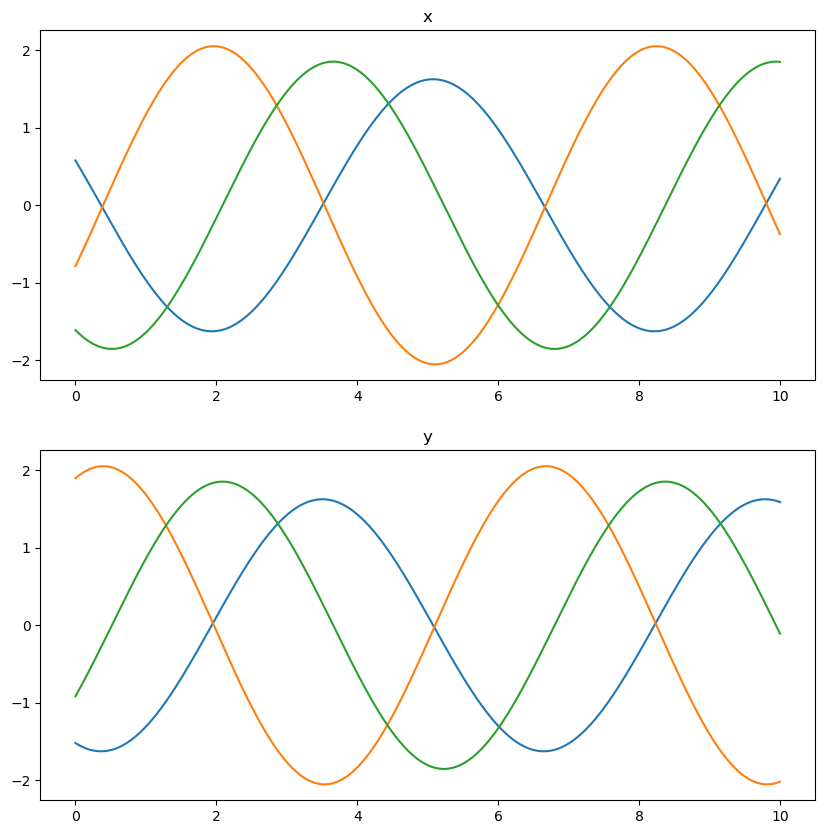

In [2]:
def vector_field(t,y,args):
    return jnp.array([y[1],-y[0]])

dim = 2
system = SystemTrajectoryGenerator(vector_field, dim, Tsit5(), ["x", "y"], args=())

key = jax.random.PRNGKey(42)
n_traj = 3
y0s = jax.random.uniform(key, (n_traj,dim)) * jnp.array([4,4]) + jnp.array([-2,-2])

y = system.generate_trajectories(y0s, 0, 10, 0.01)
system.plot_trajectories()

--------------------

Training until time 1.000100010001, with 100 samples.

--------------------
Epoch: 0
Until time: 1.634163416341634
ts shape: (100,) yi shape: (2, 100, 2)
Subset:  100 of 100 time points


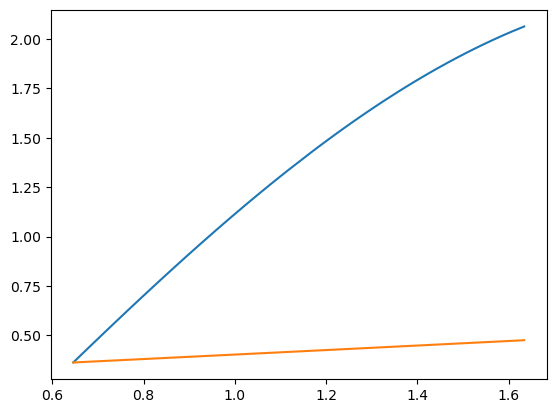

Until time: 1.6101610161016102
ts shape: (100,) yi shape: (2, 100, 2)
Subset:  100 of 100 time points


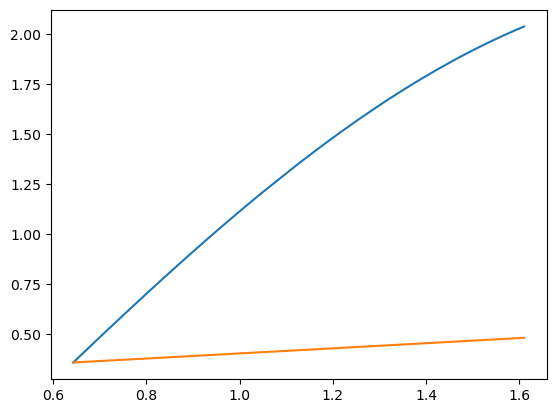

Train loss: 0.8659086096092743, Valid loss: 0.7844556002629105
--------------------
Epoch: 1
Until time: 9.735973597359736
ts shape: (100,) yi shape: (2, 100, 2)
Subset:  100 of 100 time points


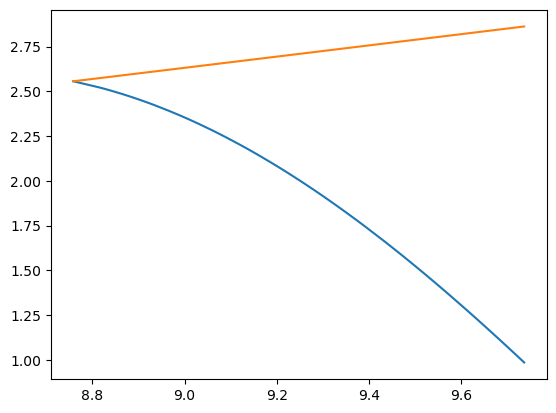

Until time: 9.736973697369738
ts shape: (100,) yi shape: (2, 100, 2)
Subset:  100 of 100 time points


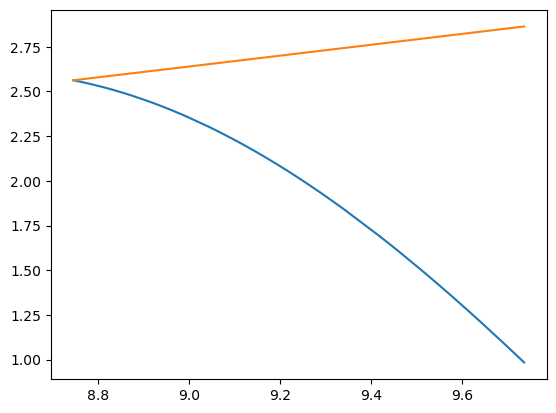

Train loss: 0.8247983680309205, Valid loss: 0.8472228597609275
--------------------
Epoch: 2
Until time: 6.143614361436144
ts shape: (100,) yi shape: (2, 100, 2)
Subset:  100 of 100 time points


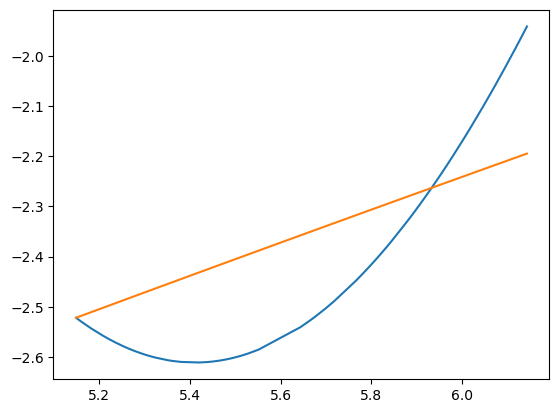

Until time: 6.136613661366137
ts shape: (100,) yi shape: (2, 100, 2)
Subset:  100 of 100 time points


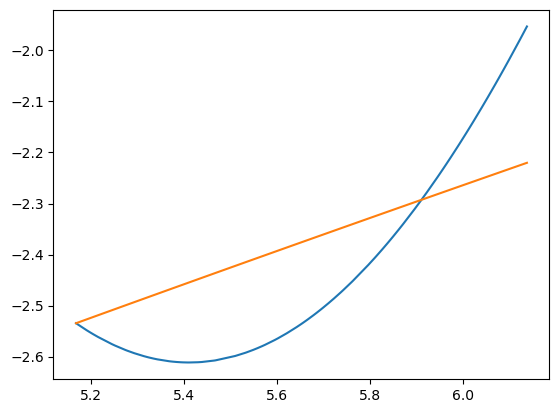

Train loss: 0.8347643993913412, Valid loss: 0.7829691978625839
--------------------
Epoch: 3
Until time: 5.777577757775777
ts shape: (100,) yi shape: (2, 100, 2)
Subset:  100 of 100 time points


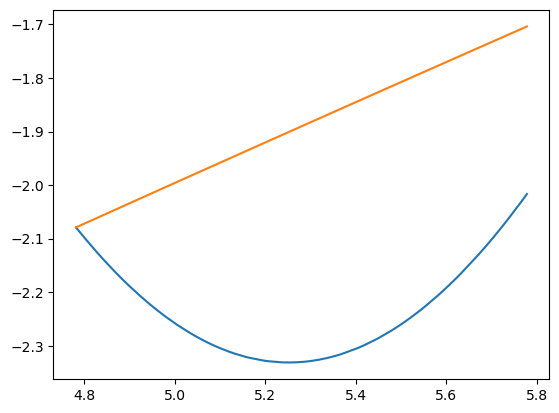

Until time: 5.755575557555756
ts shape: (100,) yi shape: (2, 100, 2)
Subset:  100 of 100 time points


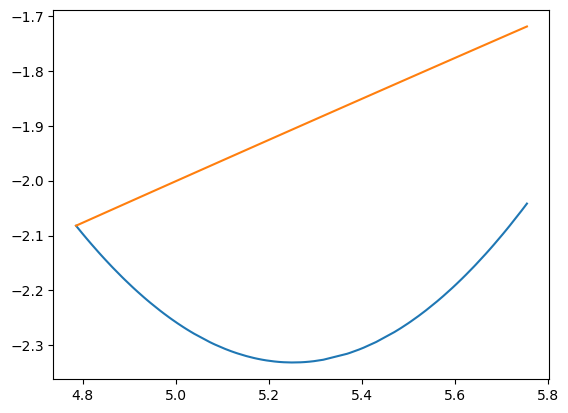

Train loss: 0.9977071435113989, Valid loss: 0.9856388854809408
--------------------
Epoch: 4
Until time: 1.5241524152415242
ts shape: (100,) yi shape: (2, 100, 2)
Subset:  100 of 100 time points


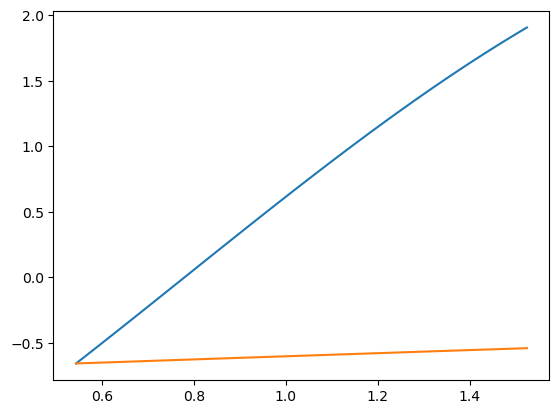

Until time: 1.5301530153015301
ts shape: (100,) yi shape: (2, 100, 2)
Subset:  100 of 100 time points


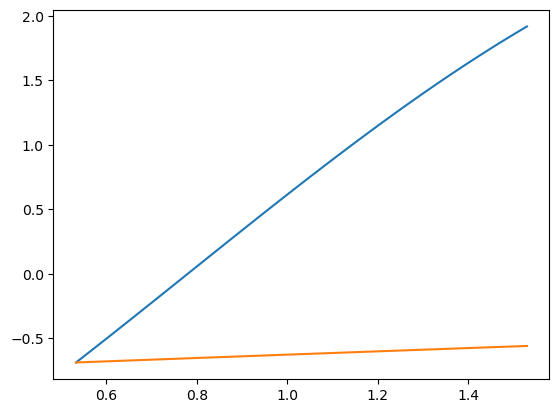

Train loss: 1.0298028547221716, Valid loss: 0.9764975447249571
--------------------

Training until time 10.0, with 200 samples.

--------------------
Epoch: 5
Until time: 9.955995599559955
ts shape: (200,) yi shape: (2, 200, 2)
Subset:  200 of 200 time points


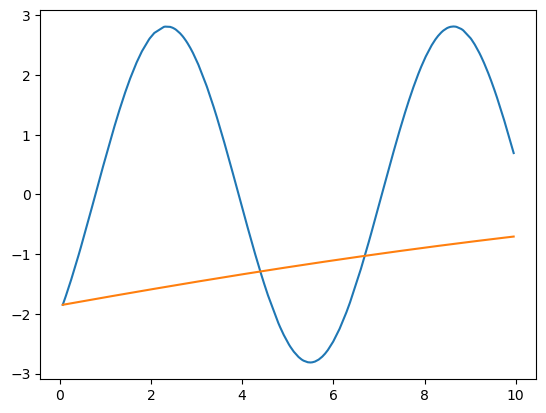

Until time: 10.0
ts shape: (200,) yi shape: (2, 200, 2)
Subset:  200 of 200 time points


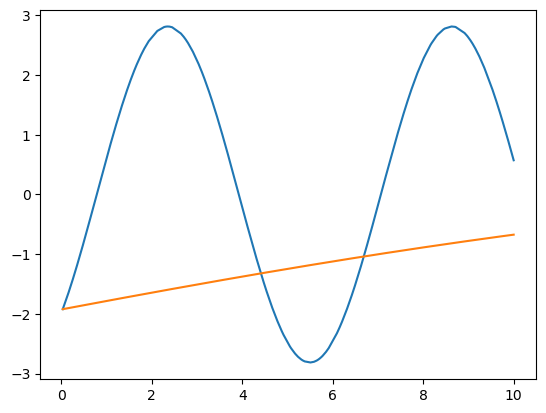

Train loss: 7.3430679778238765, Valid loss: 6.931457032581459
--------------------
Epoch: 6
Until time: 9.996999699969997
ts shape: (200,) yi shape: (2, 200, 2)
Subset:  200 of 200 time points


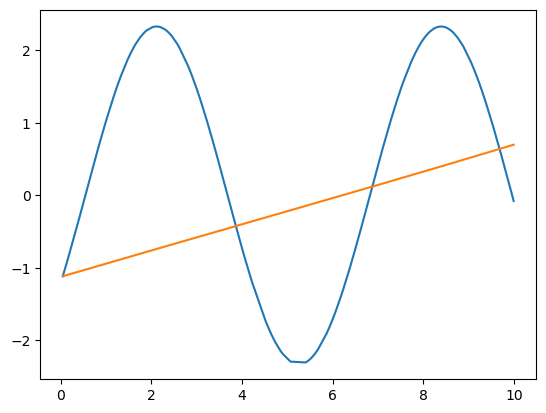

Until time: 9.986998699869988
ts shape: (200,) yi shape: (2, 200, 2)
Subset:  200 of 200 time points


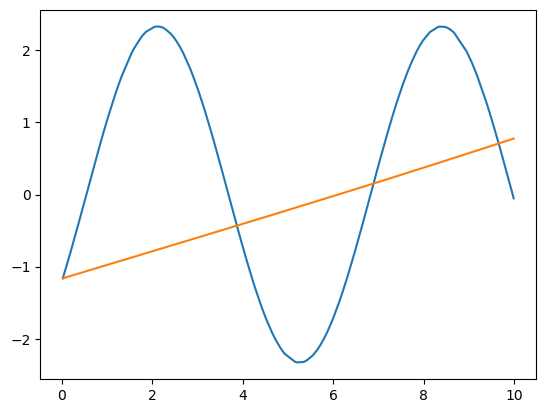

Train loss: 4.983841059486457, Valid loss: 5.057765747186533
--------------------
Epoch: 7
Until time: 9.897989798979898
ts shape: (200,) yi shape: (2, 200, 2)
Subset:  200 of 200 time points


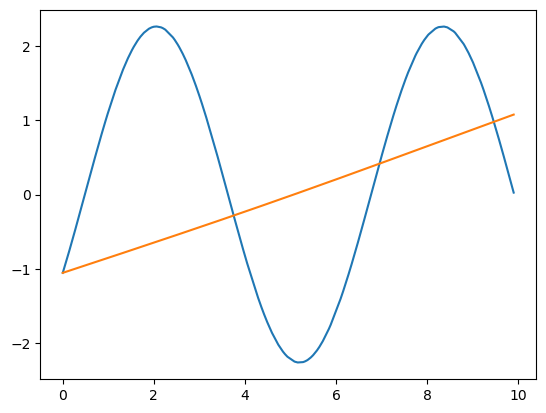

Until time: 9.954995499549955
ts shape: (200,) yi shape: (2, 200, 2)
Subset:  200 of 200 time points


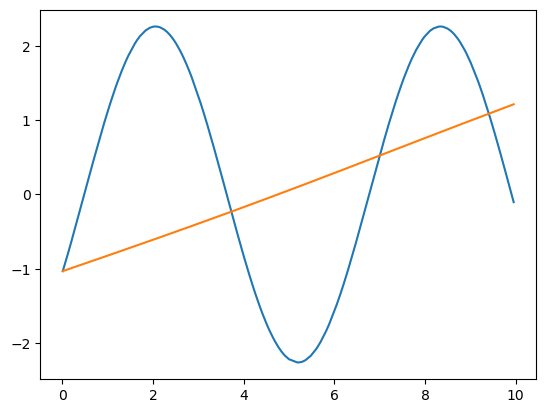

Train loss: 5.863820431715146, Valid loss: 5.982976419031935
--------------------
Epoch: 8
Until time: 9.92999299929993
ts shape: (200,) yi shape: (2, 200, 2)
Subset:  200 of 200 time points


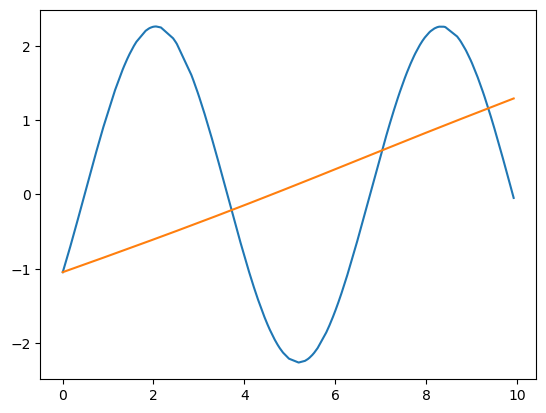

Until time: 9.975997599759976
ts shape: (200,) yi shape: (2, 200, 2)
Subset:  200 of 200 time points


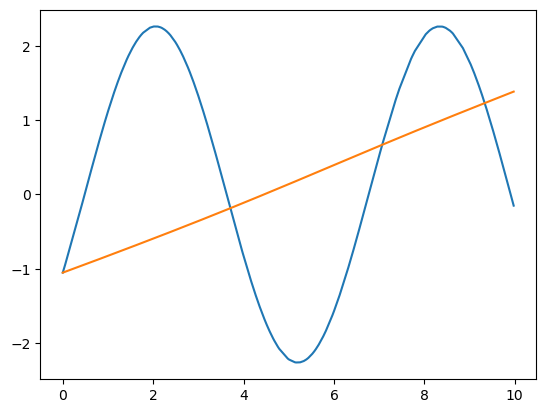

Train loss: 5.411384492850923, Valid loss: 5.5714087751457635
--------------------
Epoch: 9
Until time: 9.988998899889989
ts shape: (200,) yi shape: (2, 200, 2)
Subset:  200 of 200 time points


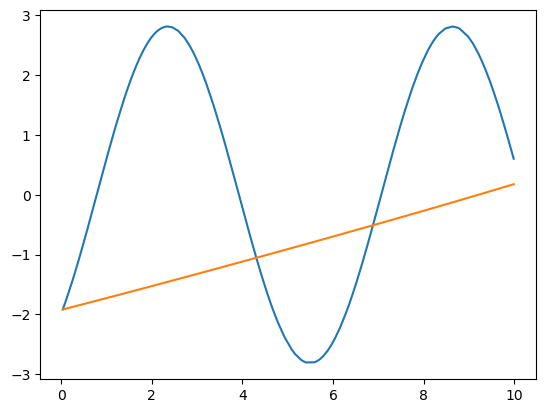

Until time: 9.983998399839985
ts shape: (200,) yi shape: (2, 200, 2)
Subset:  200 of 200 time points


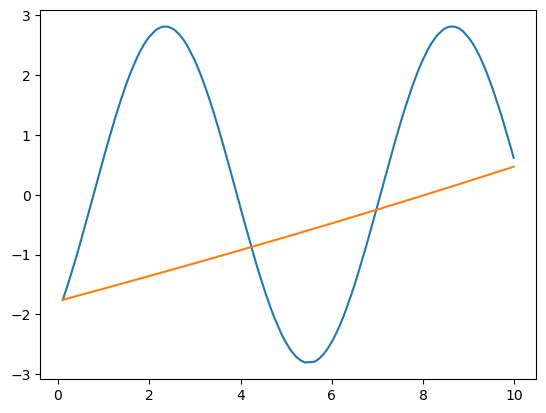

Train loss: 6.618358290719097, Valid loss: 6.5919648782824245
Training complete.
Saving model at /tmp/model_checkpoint_final


In [3]:
key = jax.random.PRNGKey(42)
model = NeuralODE(MLPVectorField, system.dim, 64, 2, 0.01, key=key)
trainer = Trainer(system, model=model)
model, train_losses, valid_losses = trainer.train(N=4, 
                                                  N_valid=4, 
                                                  n_epochs=10, 
                                                  bs=2, 
                                                  bs_valid=2, 
                                                  mins=[-2,2], 
                                                  maxs=[2,2], 
                                                  ts_train=jnp.linspace(0, 10, 10000), 
                                                  dt=1e-3,
                                                  time_windows=[1, 10],
                                                  nrand=[100, 200],
                                                  save_every=100,
                                                  seed=42,
                                                  print_status=True)

In [2]:
def SackurTetrode(S,Nkb,c_hat,V):
        return jnp.power(jnp.exp(S/Nkb)/(c_hat*V),2.0/3.0)

def M_gas(x, args):
    q, p, S1, S2 = x
    Nkb, m, alpha, L, c_hat, A_char = args
    
    V1 = A_char * q
    V2 = A_char * (2.0 * L - q)
    E1 = SackurTetrode(S1, Nkb, c_hat, V1)
    E2 = SackurTetrode(S2, Nkb, c_hat, V2)
    
    factor = 9.0 * (Nkb**2) * alpha / 4.0
    
    M = jnp.zeros((4, 4), dtype=x.dtype)
    M = M.at[2, 2].set(factor / (E1**2))
    M = M.at[2, 3].set(-factor / (E1 * E2))
    M = M.at[3, 2].set(-factor / (E1 * E2))
    M = M.at[3, 3].set(factor / (E2**2))
    
    return M

def E_gas(x, args):
    q, p, S1, S2 = x
    Nkb, m, alpha, L_, c_hat, A_char = args
    
    E_kin = p**2 / (2 * m)
    
    V1 = A_char * q
    V2 = A_char * (2.0 * L_ - q)
    
    E1 = SackurTetrode(S1, Nkb, c_hat, V1)
    E2 = SackurTetrode(S2, Nkb, c_hat, V2)
    
    return E_kin + E1 + E2

def S_gas(x, args):
    q, p, S1, S2 = x
    return S1 + S2

def L_gas(x, args):
    return jnp.array([
        [0.,  1., 0., 0.],
        [-1., 0., 0., 0.],
        [0.,  0., 0., 0.],
        [0.,  0., 0., 0.],
    ], dtype=x.dtype)

def gradE_gas(x, args):
    return jax.grad(lambda x_: E_gas(x_, args))(x)

def gradS_gas(x, args):
    return jax.grad(lambda x_: S_gas(x_, args))(x)

def two_gas_container(t, y, args):
    L = L_gas(y, args)
    M = M_gas(y, args)
    grad_E = gradE_gas(y, args)
    grad_S = gradS_gas(y, args)
    return L@grad_E + M@grad_S

Nkb = 1 # Number of particles and Boltzmann constant (characteristic unit of entropy)
m = 1 # Mass of wall
alpha = 8 # 
length = 1 # Distance from origin to the middle of the container (equilibrium wall position)
c_hat = 1 # Energy normalization
A_char = 1 # Average cross-sectional area
args = (Nkb, m, alpha, length, c_hat, A_char)

dim = 4
system = MetriplecticSystem([L_gas,M_gas,E_gas,S_gas], dim, Tsit5(), ["q", "p", "S1", "S2"], args)

"""
key = jax.random.PRNGKey(42)
n_traj = 6
y0s = jax.random.uniform(key, (n_traj,dim)) * jnp.array([1.75, 2, 2.0, 2.0]) + jnp.array([0.0, -1.0, 1.0, 1.0])

y = system.generate_trajectories(y0s, 0, 10, 0.01)
system.plot_trajectories()
"""

'\nkey = jax.random.PRNGKey(42)\nn_traj = 6\ny0s = jax.random.uniform(key, (n_traj,dim)) * jnp.array([1.75, 2, 2.0, 2.0]) + jnp.array([0.0, -1.0, 1.0, 1.0])\n\ny = system.generate_trajectories(y0s, 0, 10, 0.01)\nsystem.plot_trajectories()\n'

y0 shape:  (10, 4)
y0:  [1.20177854 0.0762731  1.77463682 2.86727315]
y_true shape:  (10, 10000, 4)
y_model shape:  (10, 10000, 4)
Loss:  1.3442598409838316e-09


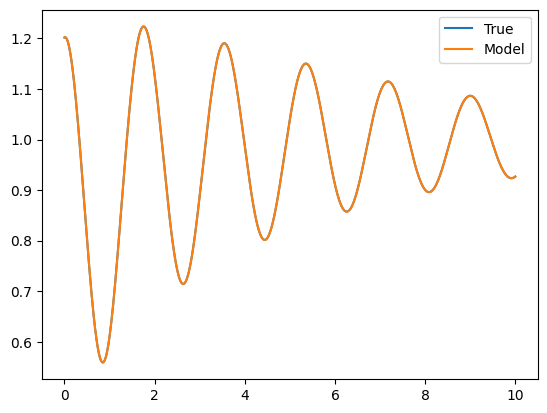

In [4]:
dim = 4
n_sample = 0
n_dim = 0
y0 = jax.random.uniform(key, (10,dim)) * jnp.array([1.0, 0.4, 2.0, 2.0]) + jnp.array([0.5, -0.2, 1, 1])
print("y0 shape: ", y0.shape)
print("y0: ", y0[n_sample,:])
t0 = 0.0
t1 = 10.0
dt = 1e-3
ts = np.linspace(t0,t1,int((t1-t0)/dt))

y_true = system.generate_trajectories(y0, t0, t1, dt)
y_model = jax.vmap(model, in_axes=(None, 0))(ts, y0)

print("y_true shape: ", y_true.shape)
print("y_model shape: ", y_model.shape)
print("Loss: ", jnp.mean((y_true - y_model) ** 2))

plt.plot(ts,y_true[n_sample,:,n_dim], label="True")
plt.plot(ts,y_model[n_sample,:,n_dim], label="Model")
plt.legend()